# Optimization Demo

This notebook includes our work on the optimization of SGHMC algorithm. We try several ways such as JIT with `Numba`, AOT with `Cython` and `C++` on simulation 1.

In [1]:
import numpy as np
import numpy.random as random
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cython

warnings.filterwarnings('ignore')

## Plain Python implementation

In [2]:
def sghmc( gradU, x0, C, V, n_samples=1000, n_steps=1, epsilon=0.1):
    
    np.random.seed(663)
    
    B = 0.5 * epsilon * V
    C, V = np.asarray(C), np.asarray(V)
    n_params = x0.shape[0]
    D = np.sqrt(2*(C-B)*epsilon) if n_params == 1 else la.cholesky(2*(C-B)*epsilon) 
    
    samples = np.zeros((n_samples, n_params))
    samples[0] = x0
    
    for i in range(n_samples-1):
        x = samples[i]
        p = np.random.randn(n_params)
        
        for j in range(n_steps):
            x = x + epsilon * p
            p = p - epsilon * gradU(x) - epsilon * np.dot(C,p) - np.dot(D,random.randn(n_params))
        
        samples[i+1] = x
    
    return samples

In [3]:
U = lambda x: -2 * x**2 + x**4
gradU =  lambda x: - 4 * x +  4 * x**3 + np.random.randn()

## Profiling

In [4]:
profile = %prun -r -q sghmc(gradU, np.array([0]), C=3, V=4, n_samples=1000, n_steps=10)
profile.sort_stats('cumtime').print_stats(10)
pass

          90920 function calls in 0.320 seconds

   Ordered by: cumulative time
   List reduced from 13 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.320    0.320 {built-in method builtins.exec}
        1    0.000    0.000    0.320    0.320 <string>:1(<module>)
        1    0.102    0.102    0.320    0.320 <ipython-input-2-5c3cce2650b9>:1(sghmc)
     9990    0.088    0.000    0.101    0.000 <ipython-input-3-4a982b873183>:2(<lambda>)
    19980    0.038    0.000    0.094    0.000 <__array_function__ internals>:2(dot)
    19980    0.045    0.000    0.045    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    20979    0.035    0.000    0.035    0.000 {method 'randn' of 'numpy.random.mtrand.RandomState' objects}
    19980    0.011    0.000    0.011    0.000 multiarray.py:707(dot)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        3    0.000

We can see that `np.dot`, `np.random.randn`, lambda function of the gradient are called the most times during the execution. The profiling helps us to focus on the part of the function that needs improvement.

As we start to optimize the function, we store the true value and make sure the optimizaiton is correct firstly.

In [5]:
sol = sghmc(gradU, np.array([0]), C=3, V=4, n_samples=1000, n_steps=10)

In [6]:
%timeit sghmc(gradU, np.array([0]), C=3, V=4, n_samples=1000, n_steps=10)

205 ms ± 9.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## JIT with `numba`

We use the `numba.jit` decorator which will trigger generation and execution of compiled code when the function is first called.

In [7]:
from numba import jit

In [8]:
@jit(cache=True)
def sghmc_numba( U, gradU, x0, C, V, n_samples=1000, n_steps=1, epsilon=0.1):
    '''SGHMC Numba'''
    
    np.random.seed(663)
    
    B = 0.5 * epsilon * V
    C, V = np.asarray(C), np.asarray(V)
    n_params = x0.shape[0]
    D = np.sqrt(2*(C-B)*epsilon) if n_params == 1 else la.cholesky(2*(C-B)*epsilon) 
    
    samples = np.zeros((n_samples, n_params))
    samples[0] = x0
    
    for i in range(n_samples-1):
        x = samples[i]
        p = np.random.randn(n_params)
        
        for j in range(n_steps):
            x = x + epsilon * p
            p = p - epsilon * gradU(x) - epsilon * np.dot(C,p) - np.dot(D,random.randn(n_params))
        
        samples[i+1] = x
    
    return samples

In [9]:
func = sghmc_numba
print(np.allclose(func(U, gradU, np.array([0]), C=3, V=4, n_samples=1000, n_steps=10), sol))

%timeit func(U, gradU, np.array([0]), C=3, V=4, n_samples=1000, n_steps=10)

True
206 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Doesn't seem to have significant improvement with Numba. Most likely because the function we write is not completely in plain Python.

## AOT with `Cython`

In [10]:
%load_ext cython

In [11]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np
import scipy.linalg as la
from libc.math cimport sqrt


@cython.boundscheck(False)
@cython.wraparound(False)
def sghmc_cython_1(gradU, double[:] x0, double [:,:] C, double [:,:] V, int n_samples=1000, int n_steps=50, double epsilon=0.1):
    '''SGHMC Cython'''
    
    cdef int n_params = x0.shape[0]
    cdef double [:,:] B = np.empty((n_params, n_params))
    cdef double [:,:] D = np.empty((n_params, n_params))
    cdef double [:,:] samples = np.empty((n_samples, n_params))
    cdef double [:] p = np.empty(n_params)
    cdef double [:] x = np.empty(n_params)
    cdef double [:] tmpgrad = np.empty(n_params)
    cdef double [:] tmprand = np.empty(n_params)
    cdef double [:] tmpdot = np.empty(n_params)
    cdef int i, j, k, s, t
    
    np.random.seed(663)
    
    for i in range(n_params):
        for j in range(n_params):
            D[i,j] = 2*epsilon*C[i,j] - epsilon*epsilon*V[i,j]
    
    if n_params == 1:
        D[0,0] = sqrt(D[0,0])
    else:
        D = la.cholesky(D)

    samples[0, :] = x0    
    for i in range(n_samples-1):
        x = samples[i, :].copy()
        p = np.random.randn(n_params)
        
        for j in range(n_steps):
            for k in range(n_params):
                x[k] = x[k] + epsilon*p[k]
            
            #p = p - epsilon * gradU_cython(x) - epsilon * np.dot(C,p) - np.dot(D,np.random.randn(n_params))
            #tmpgrad = gradU_cython(x)
            tmpgrad = gradU(np.asarray(x))
            tmprand = np.random.randn(n_params)
            tmpdot = np.zeros(n_params)
            
            for s in range(n_params):
                for t in range(n_params):
                    tmpdot[s] = tmpdot[s] + epsilon*C[s,t]*p[t] + D[s,t]*tmprand[t]
            
            for s in range(n_params):
                p[s] = p[s] - tmpdot[s] - epsilon * tmpgrad[s]
            
            #for s in range(n_params):
            #    tmpdot[s] = 0
            
        samples[i+1, :] = x
    
    return samples

Seems like numpy under Cython will have different random mechanism. Thus we check the results by observing the posterior distribution of the samples.

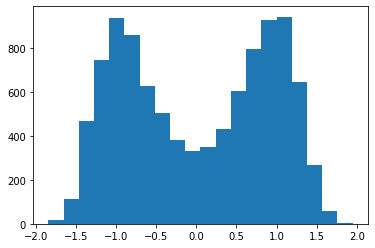

In [12]:
x = sghmc_cython_1(gradU, x0 = np.array([0.0]), C=np.array([[3.0]]), V = np.array([[4.0]]), n_samples=10000, n_steps=50)
plt.hist(np.asarray(x), bins=20)
pass

In [13]:
profile = %prun -r -q sghmc_cython_1(gradU, np.array([0.0]), C=np.array([[3.0]]), V=np.array([[4.0]]), \
                                     n_samples=1000, n_steps=10)
profile.sort_stats('cumtime').print_stats()
pass

          39967 function calls in 0.325 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.325    0.325 {built-in method builtins.exec}
        1    0.000    0.000    0.324    0.324 <string>:1(<module>)
        1    0.157    0.157    0.324    0.324 {_cython_magic_cb6b8dc36cce1eadbfe65a1bc5481dfd.sghmc_cython_1}
     9990    0.113    0.000    0.129    0.000 <ipython-input-3-4a982b873183>:2(<lambda>)
     9990    0.014    0.000    0.039    0.000 _asarray.py:16(asarray)
     9993    0.025    0.000    0.025    0.000 {built-in method numpy.array}
     9990    0.017    0.000    0.017    0.000 {method 'randn' of 'numpy.random.mtrand.RandomState' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [14]:
%timeit sghmc_cython_1(gradU, np.array([0.0]), C=np.array([[3.0]]), V=np.array([[4.0]]), n_samples=1000, n_steps=10)

206 ms ± 9.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Is gradient the bottleneck?

From the profling results we find out that the lambda function, namely the gradient calculation, is most time consuming. Thus we also implement it with Cython to see if we could boost the performance.

In [15]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np
import scipy.linalg as la
from libc.math cimport sqrt, pow

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef gradU_cython(double [:] x):
    cdef int n = x.shape[0]
    cdef double [:] y = np.empty(n)
    
    for i in range(n):
        y[i] = -4*x[i] + 4*pow(x[i], 3) + np.random.randn()
        
    return y

@cython.boundscheck(False)
@cython.wraparound(False)
def sghmc_cython_2(double[:] x0, double [:,:] C, double [:,:] V, int n_samples=1000, int n_steps=50, double epsilon=0.1):
    '''SGHMC Cython'''
    
    cdef int n_params = x0.shape[0]
    cdef double [:,:] B = np.empty((n_params, n_params))
    cdef double [:,:] D = np.empty((n_params, n_params))
    cdef double [:,:] samples = np.empty((n_samples, n_params))
    cdef double [:] p = np.empty(n_params)
    cdef double [:] x = np.empty(n_params)
    cdef double [:] tmpgrad = np.empty(n_params)
    cdef double [:] tmprand = np.empty(n_params)
    cdef double [:] tmpdot = np.empty(n_params)
    cdef int i, j, k, s, t
    
    np.random.seed(663)
    
    for i in range(n_params):
        for j in range(n_params):
            D[i,j] = 2*epsilon*C[i,j] - epsilon*epsilon*V[i,j]
    
    if n_params == 1:
        D[0,0] = sqrt(D[0,0])
    else:
        D = la.cholesky(D)

    samples[0, :] = x0    
    for i in range(n_samples-1):
        x = samples[i, :].copy()
        p = np.random.randn(n_params)
        
        for j in range(n_steps):
            for k in range(n_params):
                x[k] = x[k] + epsilon*p[k]
            
            tmpgrad = gradU_cython(x)
            tmprand = np.random.randn(n_params)
            tmpdot = np.zeros(n_params)
            
            for s in range(n_params):
                for t in range(n_params):
                    tmpdot[s] = tmpdot[s] + epsilon*C[s,t]*p[t] + D[s,t]*tmprand[t]
            
            for s in range(n_params):
                p[s] = p[s] - tmpdot[s] - epsilon * tmpgrad[s]
            
        samples[i+1, :] = x
    
    return samples

In [16]:
%timeit sghmc_cython_2(np.array([0.0]), C=np.array([[3.0]]), V=np.array([[4.0]]), n_samples=1000, n_steps=10)

72 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So the speed here is 2 times faster than in numpy, jit or Cython version without implementing the gradient. Note that in practice, we may not be able to implement the gradient or even don't have the analytical expression. The experiment here shows that bottleneck in speed results from the gradient calculation. One promising approach would be fully embed the algorithm into Tensorflow Probability because gradient calculation will be then based on tensor graph and run directly on optimized C++.

## Re-writing critical functions in C++

In [17]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <stdexcept>
#include <algorithm> // std::random_shuffle
#include <random>

#include <Eigen/LU>
#include <Eigen/Dense>

namespace py = pybind11;
using std::default_random_engine;
using std::normal_distribution;
        
// start random number engine with fixed seed
default_random_engine re{1234};
// set up random normal rnorm to work like in python
normal_distribution<double> norm(0, 1); // mean and standard deviation
auto rnorm = bind(norm, re);

// fill xs with draws from N(0,1) and return this n x 1 dim vector
Eigen::MatrixXd rnorm_vec(int n) {
    Eigen::MatrixXd xs = Eigen::MatrixXd::Zero(n, 1);
    for (int i=0; i<n; i++) {xs(i,0) = rnorm();}
    return xs;
}
    
// get noisy gradient of simulation 1
Eigen::MatrixXd gradU_noisy(Eigen::MatrixXd x) {
    Eigen::MatrixXd xs = -4*x.array() + 4*x.array().pow(3) + 2*rnorm_vec(x.rows()).array();
    return xs;
} 

// sghmc sampler
Eigen::MatrixXd run_sghmc(Eigen::MatrixXd x0, Eigen::MatrixXd C, Eigen::MatrixXd V, int n_samples, int n_steps, double epsilon){
    int n_params = x0.rows();
    Eigen::MatrixXd gradU_batch = Eigen::MatrixXd::Zero(n_params, 1);
    Eigen::MatrixXd samples = Eigen::MatrixXd::Zero(n_params, n_samples);
    Eigen::MatrixXd B = 0.5 * epsilon * V;
    Eigen::MatrixXd Sigma = 2.0 * epsilon * (C-B);
    
    Eigen::LLT<Eigen::MatrixXd> lltOfSig(Sigma);
    Eigen::MatrixXd D = lltOfSig.matrixL();

    Eigen::MatrixXd p = rnorm_vec(n_params);
    Eigen::MatrixXd x = x0;
    
    samples.col(0) = x0;
    for (int i=0; i<n_samples-1; i++) {
        p = rnorm_vec(n_params);
        
        for (int j=0; j<n_steps; j++){
            x = x + epsilon*p;
            p = p - epsilon * gradU_noisy(x) - epsilon * (C*p) - D * rnorm_vec(n_params);
        }
        samples.col(i) = x;
    }

    return samples;
}
    
PYBIND11_MODULE(wrap, m) {
    m.doc() = "auto-compiled c++ extension";
    m.def("run_sghmc", &run_sghmc);
}

Overwriting wrap.cpp


In [18]:
import cppimport

sghmc = cppimport.imp("wrap")
C = 3.0*np.eye(1)
V = 4.0*np.eye(1)
x0 = np.array([0.0])

%timeit sghmc.run_sghmc(x0, C, V, 1000, 10, 0.1)

7.05 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


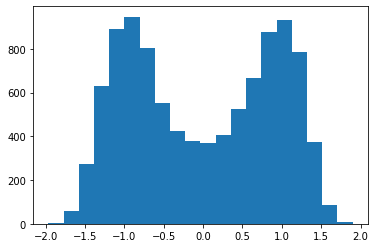

In [19]:
samples = sghmc.run_sghmc(x0, C, V, 10000, 50, 0.1)
samples_ = np.array(samples).reshape(-1, 1)
plt.hist(samples_, bins=20)
pass